# To do:


# League of Legends Machine Learning

Load libraries and API key

In [1]:
import requests, json
import numpy as np
import API_io.API_io as API_io
import importlib
import pandas as pd

In [2]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

# Get summoner names, and list of matches

Load featured games, and get a list of summoner_names

In [ ]:
featured_json = API_io.load_featured_games(api_key) # load json of featured games
featured_game_ids = [x['gameId'] for x in featured_json ] #  use list comprehension to get featured games; don't use this

Make a list of summoner names and summoner IDs from the featured JSON

In [ ]:
summoner_names, summoner_IDs = API_io.get_summoners_IDs_from_featured_games(featured_json, api_key)
summoner_names[:5]

Make a list of summoner ID urls to query RITO with, and then query them (this is rate limited to one query / 1.2 seconds to avoid overloading API).

In [ ]:
summoner_urls = [API_io.make_matchlist_url_summoner_ID(x, True, True, api_key) for x in summoner_IDs]
summoner_urls[:2]
match_histories = [API_io.get_limited_request(x) for x in summoner_urls ]

Extract the match ID from the match history JSON

In [ ]:
match_IDs = np.empty(0, dtype=int)
for cur_matches in match_histories:
    match_IDs = np.append( match_IDs, [x['matchId'] for x in cur_matches['matches']] )
pd.Series(match_IDs).to_csv('Match IDs.csv')
match_IDs.shape

### Load a csv of match info to skip above steps

In [66]:
match_df = pd.read_csv('Match IDs.csv', header =None)
match_IDs = match_df[1]
match_IDs = match_IDs.unique()
match_IDs.shape

(27928,)

## Get a JSON of data (or load it from file)

Now make a list of match url queries, and then query them; again this is rate limited. (Have not tested this for >500 queries.)

In [3]:
# load from file
with open('games 1-2000.json') as game_file:
    full_match_info = json.load(game_file)
full_match_info = np.array(full_match_info)

In [67]:
# make urls for loading
match_urls = [API_io.make_match_info_url(x, True, api_key) for x in match_IDs] # True flag means we get the timeline
match_urls[:2]

['https://na.api.pvp.net/api/lol/na/v2.2/match/1955239698?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7',
 'https://na.api.pvp.net/api/lol/na/v2.2/match/1954974642?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7']

In [68]:
import time

In [ ]:
import sys
match_range = np.arange(2000,2010)
# this for loop is ugly; used list comprehension previously, but rate limit was fluky
full_match_info = np.empty(0)
for cur_match in match_range:
    time.sleep(1.2) # RIOT API is throttled to ~0.83 requests / second
    try:
        full_match_info = np.append(full_match_info, requests.get(match_urls[cur_match]).json() )
    except requests.exceptions.HTTPError as e:
        print('Error: ' + e + ' in game ' + str(match_IDs[cur_match]))
    except:
        err = sys.exc_info()[0]
        print('Error: ' + str(err) + ' in game ' + str(match_IDs[cur_match]))

Save the JSON so we don't have to query again.

In [ ]:
with open('full match info.txt', 'w') as out_file:
    json.dump(full_match_info.tolist(), out_file)

In [ ]:
# saving as a pickle file save ~%40 of the space
import pickle
with open('test.pickle', 'wb') as pickle_file:
    pickle.dump(full_match_info, pickle_file)

# Analyze game data

## Explore and clean data

First, load some more libraries


In [4]:
import matplotlib.pyplot as plt
import API_io.plotting as lol_plt
%matplotlib inline

Plot the length of games

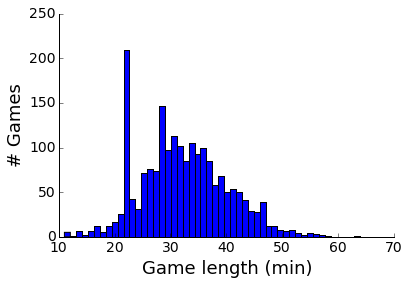

In [5]:
game_lengths = np.array([np.size(x['timeline']['frames']) for x in full_match_info] )
plt.hist(game_lengths, bins = 50);
plt.xlabel('Game length (min)', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Uh oh! Some games are too short to analyze; let's eliminate all games less than 20 minutes long.

In [6]:
full_match_info = full_match_info[game_lengths >=21]
full_match_info.shape # number of games left

(1934,)

## Create features

Create features for the classifier; now just starting with simple stuff like first blood, first tower, and first dragon.

In [7]:
from API_io import feature_calc
importlib.reload(feature_calc)
games_df = feature_calc.calc_features_all_matches(full_match_info, 20)
games_df.head()

,first_dragon,blue_dragons,red_dragons,first_baron,blue_barons,red_barons,first_tower,blue_towers,red_towers,first_inhib,...,red_inhibs,first_blood,gold_diff,blue_kills,red_kills,blue_share,red_share,surrender,game_length,winner
0,1,1,1,-1,0,0,1,3,2,-1,...,0,1,1849,14,11,0.571429,0.454545,1,37,1
1,0,0,2,-1,0,0,0,1,3,-1,...,0,1,-2110,11,11,0.363636,0.272727,1,32,0
2,0,0,1,-1,0,0,0,2,2,-1,...,0,1,-641,3,6,0.666667,0.500000,0,44,0
3,1,1,0,-1,0,0,1,3,0,-1,...,0,1,5942,14,9,0.357143,0.333333,1,27,1
4,0,0,1,-1,0,0,1,3,1,-1,...,0,1,8496,26,13,0.346154,0.461538,0,31,1


In [19]:
games_df.dtypes

first_dragon    category
blue_dragons       int64
red_dragons        int64
first_baron     category
blue_barons      float64
red_barons       float64
first_tower     category
blue_towers        int64
red_towers         int64
first_inhib     category
blue_inhibs      float64
red_inhibs       float64
first_blood     category
gold_diff          int64
blue_kills         int64
red_kills          int64
blue_share       float64
red_share        float64
surrender       category
game_length        int64
winner          category
dtype: object

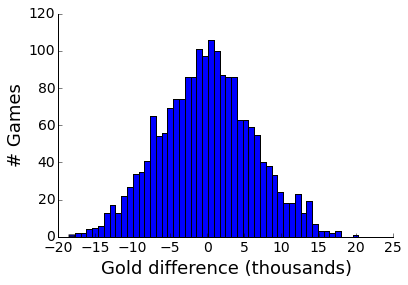

In [8]:
count, bins, _ = plt.hist(games_df['gold_diff'] / 1000, bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference (thousands)', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

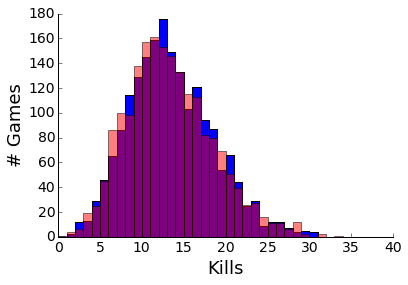

In [64]:
bins = np.arange(40)
kills_fig = plt.figure()
plt.hist(games_df['blue_kills'] , bins = bins, color = 'blue')
plt.hist(games_df['red_kills'] , bins = bins, color = 'red', alpha = 0.5)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kills', fontsize = 18)
lol_plt.prettify_axes(plt.gca())
#plt.gca().set_xticklabels(bins / 1000, rotation = 90)

# Run machine learning algorithms: 
## Load libraries, and initialize feature info

In [9]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation

In [11]:
# variables for classifiers
col_names = feature_calc.col_names
num_features = np.size(col_names) - 1
train_col = games_df.columns[:num_features]
train_col

Index(['first_dragon', 'blue_dragons', 'red_dragons', 'first_baron',
       'blue_barons', 'red_barons', 'first_tower', 'blue_towers', 'red_towers',
       'first_inhib', 'blue_inhibs', 'red_inhibs', 'first_blood', 'gold_diff',
       'blue_kills', 'red_kills', 'blue_share', 'red_share', 'surrender',
       'game_length'],
      dtype='object')

## Naive Bayes:

First let's see how good prediction is with each feature individually

In [ ]:
gnb = GaussianNB()
def quick_score(games_df, col_index):
    gnb.fit(games_df[[col_index]], games_df['winner'])
    return gnb.score(games_df[[col_index]], games_df['winner'])

[quick_score(games_df, x) for x in np.arange(num_features-1)]

First dragon and first tower are both pretty meaningful, but first blood isn't. The most important thing, though, is gold.

Now let's use machine learning to look at everything together. Let's do a 10-fold cross-validation on the data, and see what the average score is.

In [ ]:
scores = cross_validation.cross_val_score(gnb, games_df[train_col], games_df['winner'], cv=10)
print(np.mean(scores))

The full predictor is not that much more informative than the individual parameters! What if we try a:

## Feature importance

Some sample code using built in recursive feature elimination and cross-validation. I never waited long enough for this to finish!

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=3,
              scoring='accuracy')

In [ ]:
# this does not run
rfecv.fit(timelines_df[-1][train_col], timelines_df[-1]['winner'])

## Random Forest Feature Importance

Start with a non-cross validated random forest to get a sense of which features are important

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
big_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 199)
big_forest.fit(games_df[train_col], games_df['winner'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=199, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
importances = big_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in big_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#for f in range(10):
#    print("%d. feature %s (%f)" % (f + 1, str(train_col[indices[f]]), importances[indices[f]]))

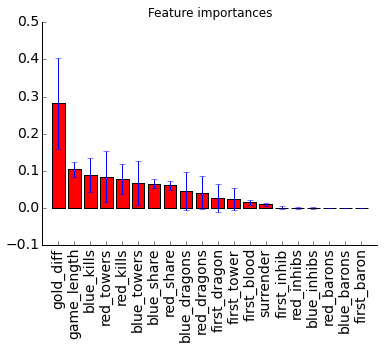

In [43]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
x_tick_labels = [str(x) for x in train_col[indices]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
lol_plt.prettify_axes(plt.gca())
plt.show()

Gold differential is the most important feature, as one might guess. By twenty minutes, features like first blood, dragon, and tower are less important. Let's narrow our features to the top ten.

In [48]:
important_col = train_col[indices[:10]]
important_col

Index(['gold_diff', 'game_length', 'blue_kills', 'red_towers', 'red_kills',
       'blue_towers', 'blue_share', 'red_share', 'blue_dragons',
       'red_dragons'],
      dtype='object')

## Does game get more predictable over time?

Let's create 4 data frames, with gold, kills, and other features at 5-20 minutes.

In [45]:
timeline_end = 25
time_indices = np.arange(5, timeline_end, 5)
timelines_df = [feature_calc.calc_features_all_matches(full_match_info, x) for x in time_indices]

In [35]:
def cross_validate_df(games_df):
    return cross_validation.cross_val_score(rfc, games_df[important_col], games_df['winner'], cv=10)

scores_list = [cross_validate_df(x) for x in timelines_df]

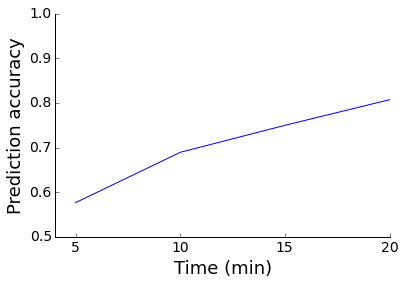

In [43]:
plt.plot(time_indices, np.mean(scores_list, 1))
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())

## Are surrendered games winnable?

First, separate games into surrendered early, and those that were semi-close.

In [27]:
surrender_at_20_df = games_df.query('(surrender == 1) & (game_length <=25)')
good_games_df = games_df.query('(surrender == 0) | (game_length >25)')

,first_dragon,blue_dragons,red_dragons,first_baron,blue_barons,red_barons,first_tower,blue_towers,red_towers,first_inhib,...,red_inhibs,first_blood,gold_diff,blue_kills,red_kills,blue_share,red_share,surrender,game_length,winner
0,1,1,1,-1,0,0,1,3,2,-1,...,0,1,1849,14,11,0.571429,0.454545,1,37,1
1,0,0,2,-1,0,0,0,1,3,-1,...,0,1,-2110,11,11,0.363636,0.272727,1,32,0
2,0,0,1,-1,0,0,0,2,2,-1,...,0,1,-641,3,6,0.666667,0.500000,0,44,0
3,1,1,0,-1,0,0,1,3,0,-1,...,0,1,5942,14,9,0.357143,0.333333,1,27,1
4,0,0,1,-1,0,0,1,3,1,-1,...,0,1,8496,26,13,0.346154,0.461538,0,31,1


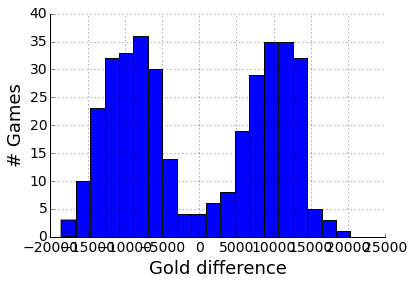

In [38]:
surrender_at_20_df['gold_diff'].hist(bins=20)
plt.xlabel('Gold difference', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Since these are stomps, the gold difference is bimodal towards large leads. However, there are a few games with small gold leads. First, let's see how accurate the random forest is for these stomps. (It should be high!)

In [51]:
surrender_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 10)
cross_validation.cross_val_score(surrender_forest, surrender_at_20_df[important_col], surrender_at_20_df['winner'], cv=10)

array([ 0.97297297,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.97142857])

Pretty damn good! Ok, what happens if we train the model on the "close" games, and apply it to the surrendered ones?

In [52]:
close_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 20)
close_forest.fit(good_games_df[important_col], good_games_df['winner'])
close_forest.score(surrender_at_20_df[important_col], surrender_at_20_df['winner'])

0.99447513812154698

Wow! If your team surrenders at 20, it was really probably an unwinnable game.